### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Tercera tarea programada 2022-I

### Parte 2 - ejercicio 2


Estudiantes: Juan Ignacio Navarro Navarro

### 1) Descripción del problema y el objetivo del ejercicio

Se desea utilizar una red neuronal recurrente LSTM utilzando pytorch para realizar un algortimo capaz de predecir la calificación dad por un comprrador. Estas calificaciones están relacionadas a el servicio de alquiler de apartamentos en una página web.

Se utilizará como base para entrenar el modelo los datos de miles de revisiones anteriores y su respectiva calificación.

El objetivo de este ejercicio es experimentar con el flujo completo de trabajo en un proyecto de aprendizaje automático para realizar análisis de sentimientos a partir de datos en lenguaje natural.

### 2) Datos utilizados en el ejercicio

Para este ejercicio se tomarán datos relacionados a las calificaciones de los usuarios usando el lenguaje natural para determinar el nivel de satisfacción con el servicio en el alquiler de apartamentos. 

Estos datos se encuentran en la siguiente dirección https://www.kaggle.com/code/wiktorbrk/trip-advisor-reviews-sentiment-analysis/notebook  de igual forma estos no son tan pesados como los del ejercicio anterior por lo que sí se incluyen en los datos en el zip de la entrega en el csv llamado tripadvisor_hotel_reviews.csv.

Note que este archivo está compuesto de aproximadamente 20500 opiniones que dividen con la opinión textual y un número de  1 a 5 añadido por el mismo usuario. 

La idea de este ejercicio es a partir de algunas de las 20500 lograr formar un modelo capaz de predecir otra calificación solamente con el texto del lenguaje natural.

### 3) Cargue y prepare los datos para ser introducidos a la red LSTM

Primero se procede a importar las bilbiotecas necesarias para el ejercicio

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plot

torch.manual_seed(1)

Definición de funciones útiles para la carga de los datos. (aquí también se incluyen otras funciones de caracter general)

In [52]:
# Funciones generales

def max_values(x):
    # Retorna el valor máximo y en índice o la posición del valor en un vector x.
    # Parámetros: 
    #    x: vector con los datos. 
    # Salida: 
    #    out: valor 
    #    inds: índice
    out, inds = torch.max(x,dim=1)   
    return out, inds

# Preparación de los datos 
def prepare_sequence(seq, to_ix):
    # Retorna un tensor con los indices del diccionario para cada palabras en una oración.
    # Parámetros:
    #   seq: oración
    #   to_ix: diccionario de palabras.
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Preparación de los datos 
def prepare_sequence_rating(seq, value, to_ix):
    # Retorna un tensor con los indices del diccionario para cada palabras en una oración.
    # Parámetros:
    #   seq: oración
    #   to_ix: diccionario de palabras.
    idxs = [value for w in range(len(seq))]
    return torch.tensor(idxs, dtype=torch.long)

In [53]:
# carga de los datos desde el csv con pandas
df = pd.read_csv(r'tripadvisor_hotel_reviews.csv')
# transformacion a minuscula
df.columns = df.columns.str.lower()

# Diccionario de palabras con su calificación
training_data = []
for i in df.index:
    if (i > 40):
        break
    elem_tuple = df["review"][i].split(), int(df["rating"][i])
    training_data.append(elem_tuple)

# Diccionario las palabras
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)


# Diccionariod e las etiquetas de cada posible calificación
tag_to_ix = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


#Ejemplo de procesamiento de una oración
inputs = prepare_sequence(training_data[0][0], word_to_ix)
print(training_data[0][0])                          
print(inputs)


['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary,', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'did', 'valet', 'parking,', 'check', 'quick', 'easy,', 'little', 'disappointed', 'non-existent', 'view', 'room', 'room', 'clean', 'nice', 'size,', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows,', 'not', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway,', 'maybe', 'just', 'noisy', 'neighbors,', 'aveda', 'bath', 'products', 'nice,', 'did', 'not', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer,', 'location', 'great', 'walking', 'distance', 'shopping,', 'overall', 'nice', 'experience', 'having', 'pay', '40', 'parking', 'night,']
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  1,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 26, 27,  0, 28, 29

### 4) Calcule algunas estadísticas importantes

Se la cantidad de registros por clase es la siguiente

---Estadísticas de los datos---
Hay  3  para la categoría  0
Hay  5  para la categoría  1
Hay  5  para la categoría  2
Hay  16  para la categoría  3
Hay  12  para la categoría  4


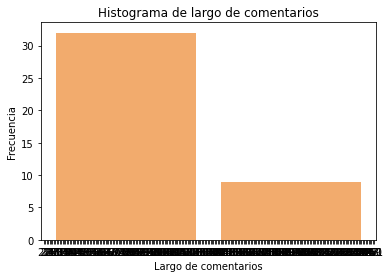

In [57]:
# Uutilizando el diccionario de entrenamiento se calcula la
# de palabras con cierta calificación del 1 al 5

lista_registros = [0] * 5
lista_ext_comentarios = []

for sent, tags in training_data:

    # Actualización de lista de registros por clase
    if (tags == 1):
        lista_registros[0] += 1
    if (tags == 2):
        lista_registros[1] += 1
    if (tags == 3):
        lista_registros[2] += 1
    if (tags == 4):
        lista_registros[3] += 1
    if (tags == 5):
        lista_registros[4] += 1

    # Actualizar lista del largo de comentarios
    lista_ext_comentarios.append(len(sent))

lista_ext_comentarios.sort()

def imprimir_distribucion(lista_distro, lista_comentarios):
    """
    Esta función se encarga de imprimir las estadísticas importantes
    para el priblema como la cantidad de registros por clasei y distribución
    del largo de comentarios.
    """
    print("---Estadísticas de los datos---")
    for i in range(5):
        print("Hay ", lista_registros[i], " para la categoría ", i)

    plot.hist(x=lista_comentarios, bins=20, color='#F2AB6D', rwidth=0.85)
    plot.title('Histograma de largo de comentarios')
    plot.xlabel('Largo de comentarios')
    plot.ylabel('Frecuencia')
    plot.xticks(intervalos)

    # Realizar un histograma para los comentarios

imprimir_distribucion(lista_registros, lista_ext_comentarios)

In [47]:
# Definición del modelo

# El modelo es una clase que debe heredar de nn.Module
class LSTMTagger(nn.Module):
    
    # Incialización del modelo
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
 

        # Primero se pasa la entrada a través de una capa Embedding. 
        # Esta capa construye una representación de los tokens de 
        # un texto donde las palabras que tienen el mismo significado 
        # tienen una representación similar.
        
        # Esta capa captura mejor el contexto y son espacialmente 
        # más eficientes que las representaciones vectoriales (one-hot vector).
        # En Pytorch, se usa el módulo nn.Embedding para crear esta capa, 
        # que toma el tamaño del vocabulario y la longitud deseada del vector 
        # de palabras como entrada. 
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # El LSTM toma word_embeddings como entrada y genera los estados ocultos
        # con dimensionalidad hidden_dim.  
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # La capa lineal mapea el espacio de estado oculto 
        # al espacio de clases
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        # Pasada hacia adelante de la red. 
        # Parámetros:
        #    sentence: la oración a procesar
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))

        # Se utiliza softmax para devolver la probabilidad de cada etiqueta
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [48]:
# Instanciación del modelo, definición de la función de pérdida y del optimizador   

# Hiperparámetros de la red
# Valores generalmente altos (32 o 64 dimensiones).
# Se definen pequeños, para ver cómo cambian los pesos durante el entrenamiento.

EMBEDDING_DIM = 6
HIDDEN_DIM = 6

# Instancia del modelo
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

# Función de pérdida: Negative Log Likelihood Loss (NLLL). 
# Generalmente utilizada en problemas de clasificacion con C clases.
loss_function = nn.NLLLoss()

# Optimizador Stochastic Gradient Descent  
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [49]:
# Entrenamiento del modelo 

# Valores antes de entrenar
# El elemento i, j de la salida es la puntuación entre la etiqueta j para la palabra i.
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    
    print(training_data[0][0])
    
    # Clasificación    
    print(tag_scores)

# Épocas de entrenamiento
for epoch in range(20):  
    for sentence, tags in training_data:
        ## Paso 1. Pytorch acumula los gradientes.
        # Es necesario limpiarlos
        model.zero_grad()

        # Paso 2. Se preparan las entradas, es decir, se convierten a
        # tensores de índices de palabras.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence_rating(sentence, tags, tag_to_ix)

        # Paso 3. Se genera la predicción (forward pass).
        tag_scores = model(sentence_in)

        # Paso 4. se calcula la pérdida, los gradientes, y se actualizan los 
        # parámetros por medio del optimizador.
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# Despligue de la puntuación luego del entrenamiento
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
   
    print("Resultados luego del entrenamiento para la primera frase")
    # Las palabras en una oración se pueden etiquetar de tres formas.
    # La primera oración tiene 4 palabras "El perro come manzana"
    # por eso el tensor de salida tiene 4 elementos. 
    # Cada elemento es un vector de pesos que indica cuál etiqueta tiene más
    # posibilidad de estar asociada a la palabra. Es decir hay que calcular 
    # la posición del valor máximo
    print(tag_scores)

['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary,', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'did', 'valet', 'parking,', 'check', 'quick', 'easy,', 'little', 'disappointed', 'non-existent', 'view', 'room', 'room', 'clean', 'nice', 'size,', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows,', 'not', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway,', 'maybe', 'just', 'noisy', 'neighbors,', 'aveda', 'bath', 'products', 'nice,', 'did', 'not', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer,', 'location', 'great', 'walking', 'distance', 'shopping,', 'overall', 'nice', 'experience', 'having', 'pay', '40', 'parking', 'night,']
tensor([[-2.0918, -1.5147, -1.6123, -1.6473, -1.9857, -2.0606],
        [-2.1342, -1.5641, -1.5707, -1.6032, -1.9254, -2.1421],
        [-1.9423, 

In [50]:
# ¿Cómo se probaría el modelo?

def test_examples(test_data):

   with torch.no_grad():
      inputs = prepare_sequence(test_data, word_to_ix)
      tag_scores = model(inputs)
    
 
   print("FRASE") 
   print("La frase original", test_data)    
   print("La frase original preprocesada", inputs)
   print("Salida del modelo", tag_scores)
   print("Valores máximos e índices", max_values(tag_scores))    
    

#print("Índice de palabras")
#print("word_to_idx", word_to_ix)

print("Clases")
print(tag_to_ix)

#Frase 1
# Las palabras en una oración se pueden etiquetar de tres formas.
# La primera oración tiene 3 palabras "El perro juega"
# por eso el tensor de salida tiene 3 elementos. 
# Cada elemento es un vector de probabilidad de estar asociada a una clase. 
# Es decir hay que calcular la posición del valor máximo. 
#   Ejemplo 1: "El perro juega" ["DET", "NN", "V"]
# Ejemplo: salida 0, 1, 2 con {"DET": 0, "NN": 1, "V": 2} => DET, NN, V 
test_examples(test_data[0][0])

Clases
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


NameError: name 'test_data' is not defined